Processing xception...


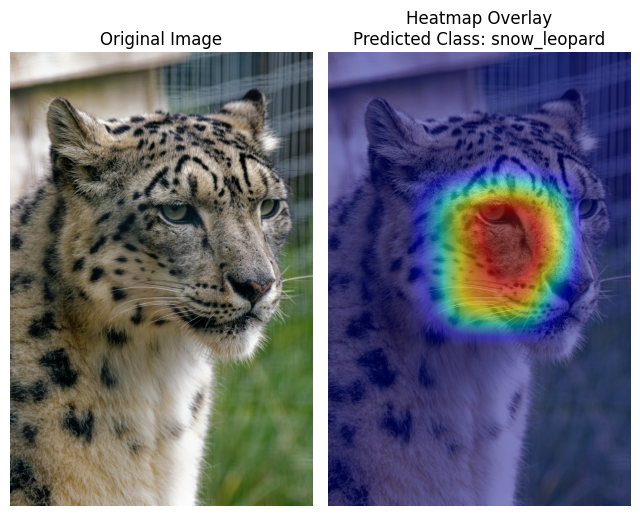

Processing resnet50...


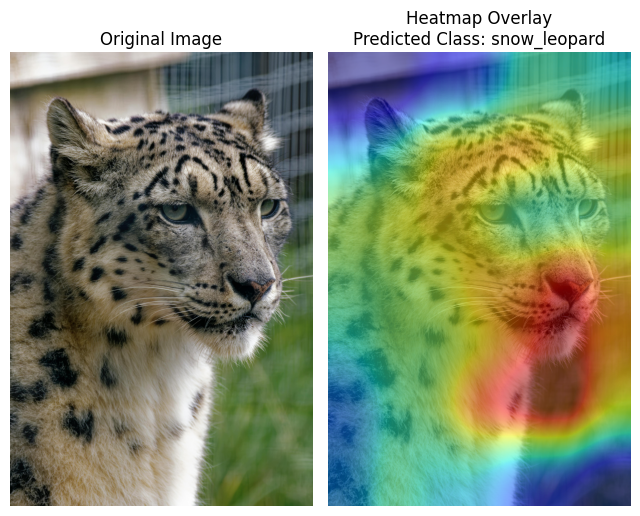

Processing vgg19...


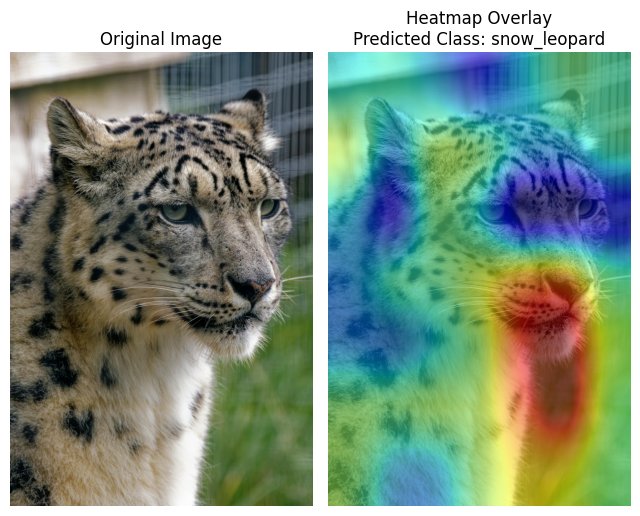

In [4]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
import numpy as np
import timm
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load Pretrained Models
def load_model(model_name):
    if model_name == "xception":
        return timm.create_model('xception', pretrained=True)
    elif model_name == "resnet50":
        return models.resnet50(pretrained=True)
    elif model_name == "vgg19":
        return models.vgg19(pretrained=True)
    else:
        raise ValueError(f"Model {model_name} is not supported")

# Load ImageNet class labels for visualization
def load_imagenet_labels():
    label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
    import requests
    import json
    labels = requests.get(label_url).json()
    return {int(key): value[1] for key, value in labels.items()}

# Define GRAD-CAM
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer = dict(model.named_modules())[target_layer_name]
        self.gradients = None
        self.activation = None

        def save_gradients(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        def save_activation(module, input, output):
            self.activation = output

        self.target_layer.register_forward_hook(save_activation)
        self.target_layer.register_backward_hook(save_gradients)

    def generate_heatmap(self, input_tensor, target_class):
        # Forward pass
        output = self.model(input_tensor)
        target_score = output[:, target_class]

        # Backward pass
        target_score.backward()

        # Compute weights
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        heatmap = torch.sum(self.activation * pooled_gradients.view(1, -1, 1, 1), dim=1).squeeze()

        # Normalize and convert to numpy
        heatmap = F.relu(heatmap).cpu().detach().numpy()
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

        return heatmap

# Preprocess Input Image
def preprocess_image(image_path, model_name):
    if model_name == "xception":
        preprocess = transforms.Compose([
            transforms.Resize((299, 299)),  # Xception requires 299x299 input
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),  # ResNet and VGG require 224x224 input
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    image = Image.open(image_path).convert("RGB")
    return preprocess(image).unsqueeze(0)

# Visualize Heatmap and Display Class Name
def overlay_heatmap(image_path, heatmap, class_name, model_name):
    original_image = Image.open(image_path).convert("RGB")
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(original_image.size)
    heatmap = np.array(heatmap)

    # Overlay heatmap
    plt.figure(figsize=(8, 8))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Original Image")

    # Plot heatmap overlay
    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Heatmap overlay
    plt.axis('off')
    plt.title(f"Heatmap Overlay\nPredicted Class: {class_name}")

    # Adjust layout to remove spacing
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    output_dir = '../images'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = os.path.join(output_dir, f"{model_name}_output.png")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)

    # Display the image
    plt.show()
    plt.close()

# Example Usage for the 3 Models
def grad_cam_for_models(image_path):
    models_to_use = ["xception", "resnet50", "vgg19"]
    imagenet_labels = load_imagenet_labels()  # Load ImageNet class labels

    for model_name in models_to_use:
        print(f"Processing {model_name}...")

        # Load the model
        model = load_model(model_name)
        model.eval()

        # Select the appropriate target layer
        if model_name == "xception":
            target_layer_name = "conv4.pointwise"
        elif model_name == "resnet50":
            target_layer_name = "layer4.2.conv3"
        elif model_name == "vgg19":
            target_layer_name = "features.36" 
            
        # Initialize GradCAM for the selected model
        cam = GradCAM(model, target_layer_name)

        # Preprocess the input image
        input_tensor = preprocess_image(image_path, model_name)

        # Get the predicted class
        output = model(input_tensor)
        target_class = torch.argmax(output).item()
        class_name = imagenet_labels.get(target_class, "Unknown Class")

        # Generate the heatmap using GradCAM
        heatmap = cam.generate_heatmap(input_tensor, target_class)

        # Visualize the heatmap with the class label and save it
        overlay_heatmap(image_path, heatmap, class_name, model_name)

# Example Image Path
image_path = "../images/input_image.jpg" # snow leopard
grad_cam_for_models(image_path)